In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import glob as glob

from utils.diagnostics import compute_summary_statistics

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [3]:
model_names = ["ew_lo_sample", "mvo_ls_sample", "md_ls_sample"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [4]:
def aggregate_results(path):
    files = glob.glob(os.path.join(path, "*.csv"))

    all_summary = []
    for f in files:
        summary = pd.read_csv(f)

        all_summary.append(summary)
    
    all_summary_df = pd.concat(all_summary)
    all_summary_df.sort_values("date", inplace=True)

    return all_summary_df.reset_index(drop=True)

In [5]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [6]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo_sample,3.375364,18.326935,0.184175,0.204944,-7.206941,-46.448129,0.516463
mvo_ls_sample,-37.795305,49.504108,-0.763478,-0.575873,-49.312516,-94.975526,0.493261
md_ls_sample,0.705043,15.795246,0.044636,0.046453,-9.499109,-42.851550,0.510512


In [7]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
        index &       E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
 ew\_lo\_sample &   3.375364 & 18.326935 &  0.184175 &  0.204944 &  -7.206941 & -46.448129 &         0.516463 \\
mvo\_ls\_sample & -37.795305 & 49.504108 & -0.763478 & -0.575873 & -49.312516 & -94.975526 &         0.493261 \\
 md\_ls\_sample &   0.705043 & 15.795246 &  0.044636 &  0.046453 &  -9.499109 & -42.851550 &         0.510512 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

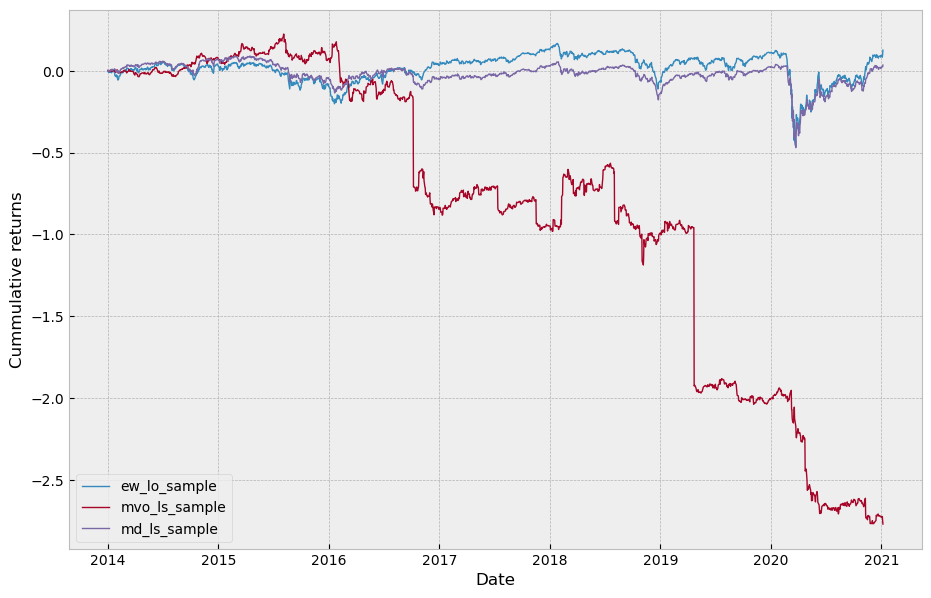

In [9]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2014-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test